<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/vitaldb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VitalDB 오픈 데이터셋 이용
오픈 생체 신호 데이터셋인 VitalDB를 이용하는 모든 사용자는 반드시 아래 Data Use Agreement에 동의하여야 합니다.

https://vitaldb.net/data-bank/?query=guide&documentId=13qqajnNZzkN7NZ9aXnaQ-47NWy7kx-a6gbrcEsi-gak&sectionId=h.usmoena3l4rb

동의하지 않을 경우 이 창을 닫으세요. 

# 라이브러리 및 데이터 로딩
VitalDB open dataset 을 이용하기 위해서는 pandas 라이브러리가 필요하다.

VitalDB open dataset의 3개의 endpoint 를 로딩한다.

In [1]:
import pandas as pd

df_cases = pd.read_csv("https://api.vitaldb.net/cases")  # 임상 정보
df_trks = pd.read_csv("https://api.vitaldb.net/trks")  # 트랙 정보
df_labs = pd.read_csv('https://api.vitaldb.net/labs')  # 검사 결과

## 임상 정보 확인
VitalDB 데이터셋의 case들과 변수들을 육안 확인해 보자.

In [2]:
df_cases

,caseid,death_inhosp,casestart,caseend,anestart,aneend,opstart,opend,adm,dis,devices,tracks,casedur,filesize,age,sex,height,weight,bmi,asa,emop,department,optype,dx,opname,approach,position,ane_type,opdur,anedur,los_postop,los_icu,preop_htn,preop_dm,preop_ecg,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_gluc,preop_alb,preop_ast,preop_alt,preop_bun,preop_cr,preop_ph,preop_hco3,preop_be,preop_pao2,preop_paco2,preop_sao2,cormack,airway,tubesize,dltubesize,lmasize,iv1,iv2,aline1,aline2,cline1,cline2,intraop_ebl,intraop_uo,intraop_rbc,intraop_ffp,intraop_crystalloid,intraop_colloid,intraop_ppf,intraop_mdz,intraop_ftn,intraop_rocu,intraop_vecu,intraop_eph,intraop_phe,intraop_epi,intraop_ca
0,1,0,0,11520,-540,10860,-540,10380,-236220,627780,4,78,192,21.3,77.0,M,160.2,67.50,26.3,2.0,0.0,General surgery,Colorectal,Rectal cancer,Low anterior resection,Open,Lithotomy,General,145.0,180.0,8.0,0.0,1.0,0.0,Normal Sinus Rhythm,Normal,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,N,Left radial,N,N,N,NaN,300.0,0.0,0.0,350.0,0.0,120.0,0.0,100.0,70.0,0.0,10.0,0.0,0.0,0.0
1,2,0,0,15720,-1020,14940,1740,14640,-221160,1506840,5,75,262,26.3,54.0,M,167.3,54.80,19.6,2.0,0.0,General surgery,Stomach,Advanced gastric cancer,Subtotal gastrectomy,Open,Supine,General,215.0,245.0,19.0,0.0,0.0,0.0,Normal Sinus Rhythm,Normal,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,50.0,700.0,0.0,0.0,800.0,0.0,150.0,0.0,0.0,100.0,0.0,20.0,0.0,0.0,0.0
2,3,0,0,4440,-540,4260,-540,3960,-218640,40560,5,80,73,6.6,62.0,M,169.1,69.70,24.4,1.0,0.0,General surgery,Biliary/Pancreas,Gallbladder stone,Cholecystectomy,Videoscopic,Reverse Trendelenburg,General,32.0,65.0,2.0,0.0,0.0,0.0,Normal Sinus Rhythm,Normal,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Left forearm,N,N,N,N,N,NaN,NaN,0.0,0.0,200.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0
3,4,0,0,21000,-720,20280,2580,18180,-201120,576480,5,74,350,28.3,74.0,M,160.6,53.00,20.5,2.0,0.0,General surgery,Stomach,Advanced gastric cancer,Distal gastrectomy,Videoscopic,Reverse Trendelenburg,General,255.0,335.0,7.0,1.0,1.0,0.0,Normal Sinus Rhythm,Normal,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,NaN,NaN,NaN,Left forearm,N,Right radial,N,N,N,NaN,270.0,0.0,0.0,2700.0,0.0,80.0,0.0,100.0,100.0,0.0,50.0,0.0,0.0,0.0
4,5,0,0,21540,-960,22440,2640,21840,-67560,3734040,6,99,359,41.0,66.0,M,171.0,59.70,20.4,3.0,1.0,General surgery,Vascular,Aortic aneurysm,Aneurysmal repair,Open,Prone,General,295.0,350.0,45.0,13.0,1.0,0.0,Left anterior fascicular block,Normal,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,NaN,NaN,NaN,NaN,NaN,NaN,I,Oral,7.5,NaN,NaN,Right forearm,N,Right radial,N,Right IJV,N,2600.0,1490.0,8.0,8.0,7100.0,0.0,0.0,0.0,0.0,160.0,0.0,10.0,900.0,0.0,2100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4131,4132,0,0,23940,-660,23580,-660,22980,-217620,819180,5,80,399,31.2,75.0,M,157.2,75.40,30.5,2.0,0.0,General surgery,Stomach,Early gastric cancer,Distal gastrectomy,Videoscopic,Supine,General,347.0,385.0,10.0,0.0,1.0,0.0,Normal Sinus Rhythm,Normal,15.3,193.0,103.0,34.7,NaN,NaN,115.0,4.4,17.0,21.0,15.0,0.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oral,7.5,NaN,NaN,Right hand,N,N,N,N,N,730.0,160.0,0.0,0.0,2200.0,500.0,0.0,0.0,0.0,140.0,0.0,0.0,0.0,0.0,0.0
4132,4133,0,0,14040,-480,13800,2280,13200,-114000,231600,6,86,233,24.9,42.0,F,152.0,47.65,20.6,1.0,0.0,General surgery,Thyroid,Papillary thyroid carcinoma,Total thyroidectomy,Robotic,Supine,General,180.0,215.0,3.0,0.0,0.0,0.0,Normal Sinus R

### 임상 정보 결측률 확인

In [3]:
print((df_cases.isnull().mean() * 100).to_string())

caseid                  0.000000
death_inhosp            0.000000
casestart               0.000000
caseend                 0.000000
anestart                0.000000
aneend                  0.000000
opstart                 0.000000
opend                   0.000000
adm                     0.000000
dis                     0.000000
devices                 0.000000
tracks                  0.000000
casedur                 0.000000
filesize                0.000000
age                     0.000000
sex                     0.000000
height                  0.000000
weight                  0.000000
bmi                     0.000000
asa                     2.030948
emop                    0.024178
department              0.024178
optype                  0.024178
dx                      0.024178
opname                  0.024178
approach                0.024178
position                3.094778
ane_type                0.024178
opdur                   0.024178
anedur                  0.024178
los_postop

## ASA class 에 따라 응급 및 정규 수술에서의 사망률

[0.8333333333333334, 0.3695150115473441, 1.2232415902140672, 0.0]
[0.0, 2.5423728813559325, 3.225806451612903, 21.052631578947366]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

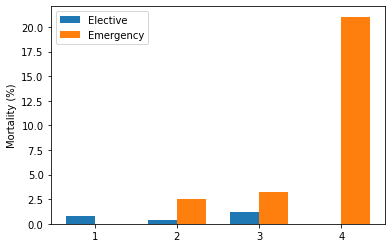

In [5]:
el_y = []  # 정규 수술 사망률
em_y = []  # 응급 수술 사망률
for asa in range(1,5):
    el_y.append(df_cases[(df_cases['asa'] == asa) & (df_cases['emop'] == 0)]['death_inhosp'].mean() * 100)
    em_y.append(df_cases[(df_cases['asa'] == asa) & (df_cases['emop'] == 1)]['death_inhosp'].mean() * 100)
print(el_y)
print(em_y)

# 그림을 그림
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
w = 0.35
x = np.arange(1,5)
ax.bar(x - w/2, el_y, w, label='Elective')
ax.bar(x + w/2, em_y, w, label='Emergency')
ax.set_ylabel('Mortality (%)')
ax.set_xticks(x)
ax.legend()
plt

## 트랙 정보 확인

In [6]:
df_trks

,caseid,tname,tid
0,1,BIS/BIS,fd869e25ba82a66cc95b38ed47110bf4f14bb368
1,1,BIS/EEG1_WAV,0aa685df768489a18a5e9f53af0d83bf60890c73
2,1,BIS/EEG2_WAV,ad13b2c39b19193c8ae4a2de4f8315f18d61a57e
3,1,BIS/EMG,2525603efe18d982764dbca457affe7a45e766a9
4,1,BIS/SEF,1c91aec859304840dec75acf4a35da78be0e8ef0
...,...,...,...
486444,6388,Solar8000/VENT_PIP,2d63adbc7e2653f14348e219816673cde3358cf6
486445,6388,Solar8000/VENT_PPLAT,6f6604255858ddc8f6a01b9f4774b0d43105f6da
486446,6388,Solar8000/VENT_RR,f34f3fae7fd963355c1c7060e1e876d20fa87536
486447,6388,Solar8000/VENT_SET_TV,4a4a55b8aebf9c76a4a76f62a7c1ec6fcb80e618


### 트랙 정보 취득률 확인

In [8]:
print('{} track types'.format(len(df_trks['tname'].unique())))
for tname in sorted(df_trks['tname'].unique()):
    print('{}\t{}'.format(tname, (df_trks['tname'] == tname).sum() / len(df_cases) * 100))


196 track types
BIS/BIS	141.85203094777563
BIS/EEG1_WAV	141.9487427466151
BIS/EEG2_WAV	141.9487427466151
BIS/EMG	134.8404255319149
BIS/SEF	134.647001934236
BIS/SQI	141.85203094777563
BIS/SR	134.647001934236
BIS/TOTPOW	134.21179883945842
CardioQ/ABP	0.7011605415860735
CardioQ/CI	0.6769825918762089
CardioQ/CO	0.7011605415860735
CardioQ/FLOW	0.7011605415860735
CardioQ/FTc	0.7011605415860735
CardioQ/FTp	0.6769825918762089
CardioQ/HR	0.7011605415860735
CardioQ/MA	0.6769825918762089
CardioQ/MD	0.7011605415860735
CardioQ/PV	0.6769825918762089
CardioQ/SD	0.7011605415860735
CardioQ/SV	0.7011605415860735
CardioQ/SVI	0.6769825918762089
EV1000/ART_MBP	14.313346228239846
EV1000/CI	14.917794970986462
EV1000/CO	14.917794970986462
EV1000/CVP	5.681818181818182
EV1000/SV	14.917794970986462
EV1000/SVI	14.917794970986462
EV1000/SVR	6.165377176015474
EV1000/SVRI	6.165377176015474
EV1000/SVV	14.917794970986462
FMS/FLOW_RATE	0.36266924564796904
FMS/INPUT_AMB_TEMP	0.36266924564796904
FMS/INPUT_TEMP	0.36266924

## 검사 결과 데이터 확인

In [11]:
print('{} lab types'.format(len(df_labs['name'].unique())))
df_labs

35 lab types


,caseid,dt,name,result
0,1641,-13205066,alb,0.10
1,6275,-26408906,alb,0.10
2,2761,-1473145,alb,0.10
3,5884,-849156,alb,0.10
4,4398,-2605364,alb,0.20
...,...,...,...,...
1060162,86,6459386,wbc,72.58
1060163,86,6632801,wbc,73.31
1060164,86,6546821,wbc,79.55
1060165,86,6723242,wbc,82.23


# VitalDB open dataset 이용의 실제

## 특정 조건을 만족하는 Case 찾기
VitalDB 데이터 이용 연구의 시작은 inclusion, exclusion criteria를 만족하는 case를 찾는 것이다. 실제로는 해당 caseid의 리스트를 구하는 것이 목적이다.

모든 VitalDB 이용 연구는 대부분 아래 코드로 시작한다.

In [17]:
df_cases['opname'].str.contains("transplant")

0       False
1       False
2       False
3       False
4       False
        ...  
4131    False
4132    False
4133    False
4134    False
4135      NaN
Name: opname, Length: 4136, dtype: object

In [18]:
caseids = list(
    set(df_trks[df_trks['tname'] == 'Solar8000/ART_MBP']['caseid']) & 
    set(df_cases[df_cases['age'] > 18]['caseid']) & 
    set(df_cases[False == df_cases['opname'].str.contains("transplant")]['caseid'])
)
print(len(caseids))

2244


## Case ID로부터 원하는 트랙을 로딩하기
가장 쉽게 트랙 데이터를 로딩하는 방법은 caseid 와 트랙명으로 로딩하는 것이다. 이를 위해 vitaldb 라이브러리를 이용한다.

In [20]:
!wget https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py

--2021-06-22 02:59:50--  https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19062 (19K) [text/plain]
Saving to: ‘vitaldb.py.1’

vitaldb.py.1        100%[===================>]  18.62K  --.-KB/s    in 0s      

2021-06-22 02:59:50 (105 MB/s) - ‘vitaldb.py.1’ saved [19062/19062]



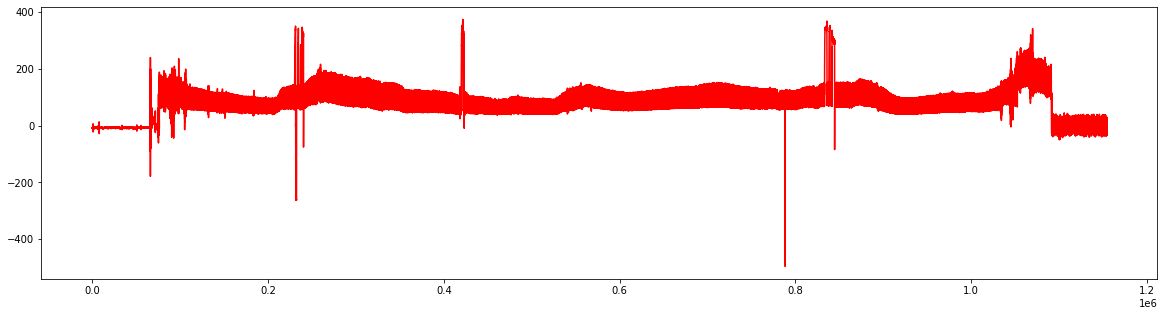

In [21]:
import vitaldb
trks = vitaldb.load_case(['SNUADC/ART','Solar8000/ART_SBP'], caseid=1, interval=1/100)

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(trks[:, 0], color='r')
plt.show()

## 트랙 ID (tid) 구하기
실제 트랙 데이터를 읽어보기 위해서는 해당 트랙의 트랙 ID (tid)가 반드시 필요하다. 트랙 ID 는 위에서 구한 caseid 와 트랙명으로부터 구한다.

* 트랙명의 전체 리스트는 아래 링크에 있다.
https://vitaldb.net/data-bank/?query=param

In [ ]:
caseid = 6388
tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/ART_MBP')]['tid'].values[0]
tid

'8132234ea9f472b48d012f50892cd495de3871c9'

# 트랙 ID로부터 실제 트랙 데이터를 받아오는 방법
트랙 ID로부터 실제 트랙 데이터를 받아오는 가장 쉬운 방법은 github에 공개된 vitaldb 라이브러리를 이용하는 것입니다.

먼저 vitaldb 라이브러리를 다운로드 합니다.

In [22]:
!wget https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py

import vitaldb

--2021-06-22 03:00:07--  https://raw.githubusercontent.com/vitaldb/vitalutils/master/python/vitaldb.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19062 (19K) [text/plain]
Saving to: ‘vitaldb.py.2’

vitaldb.py.2        100%[===================>]  18.62K  --.-KB/s    in 0s      

2021-06-22 03:00:07 (112 MB/s) - ‘vitaldb.py.2’ saved [19062/19062]



## 실제 트랙 데이터를 로딩
vitaldb.load_trk 함수를 이용하면 vitaldb 에서 실제 트랙 데이터를 로딩할 수 있다.

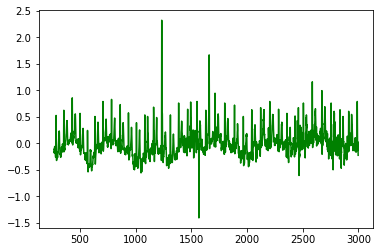

In [ ]:
ecg = vitaldb.load_trk('395df4819e4e1f0d123d14f042667975f5945504', 0.01)

import matplotlib.pyplot as plt
plt.plot(ecg[:3000], color='g')

## 여러 트랙을 한번에 로딩
vitaldb.load_trks 함수를 이용하면 vitaldb 에서 실제 트랙 데이터를 로딩할 수 있다.

In [ ]:
# 1번 case의 NIBP_SBP, NIBP_MBP, NIBP_DBP 트랙을 로딩
caseid = 1
sbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_SBP')]['tid'].values[0]
mbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_MBP')]['tid'].values[0]
dbp_tid = df_trks[(df_trks['caseid'] == caseid) & (df_trks['tname'] == 'Solar8000/NIBP_DBP')]['tid'].values[0]
print(sbp_tid)
print(mbp_tid)
print(dbp_tid)
vals = vitaldb.load_trks([sbp_tid, mbp_tid, dbp_tid], 60)
vals

eb1e6d9a963d7caab8f00993cd85bf31931b7a32
29cef7b8fe2cc84e69fd143da510949b3c271314
829134dd331e867598f17d81c1b31f5be85dddec


array([[ nan,  nan,  nan],
       [150., 100.,  84.],
       [177., 109.,  75.],
       [178.,  96.,  74.],
       [172., 102.,  77.],
       [172., 102.,  77.],
       [172., 134.,  85.],
       [125.,  74.,  60.],
       [107.,  76.,  65.],
       [107.,  76.,  65.],
       [107., 153.,  65.],
       [199., 145., 100.],
       [199., 145., 100.],
       [199., 145., 100.]])